# **2. Power Tower Molten Salt 100MW - Single Owner Example**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline


**2.1   Model Initialization**

In [2]:
import PySAM.Solarpilot as sp
import PySAM.TcsmoltenSalt as tcs
system_model_csp = tcs.default('MSPTSingleOwner')

**2.2   SystemDesign Group**

In [3]:
P_ref=111 #[MW]
Cycle_th_eff=0.412
S_M=3
Cycle_th_P=P_ref/Cycle_th_eff
tshours=15
system_model_csp.SystemDesign.P_ref=P_ref
system_model_csp.SystemDesign.solarm=S_M

In [4]:
model_opt1=sp.from_existing(system_model_csp)
model_opt1.SolarPILOT.helio_optical_error=0.00153
model_opt1.SolarPILOT.q_design=round(S_M*Cycle_th_P)
model_opt1.SolarPILOT.rec_aspect=21.6029/17.65
model_opt1.SolarPILOT.solar_resource_file="Antofagasta.csv"
model_opt1.execute()

In [5]:
system_model_csp.SystemDesign.tshours=tshours
system_model_csp.HeliostatField.helio_positions=model_opt1.Outputs.heliostat_positions
system_model_csp.TowerAndReceiver.h_tower=model_opt1.Outputs.h_tower_opt
system_model_csp.TowerAndReceiver.rec_height=model_opt1.Outputs.rec_height_opt
system_model_csp.HeliostatField.N_hel=model_opt1.Outputs.number_heliostats
system_model_csp.TowerAndReceiver.D_rec=model_opt1.Outputs.rec_height_opt/model_opt1.Outputs.rec_aspect_opt
#system_model_csp.HeliostatField.A_sf_in=model_opt1.Outputs.area_sf
system_model_csp.HeliostatField.A_sf_in=model_opt1.SolarPILOT.helio_width*model_opt1.SolarPILOT.dens_mirror*model_opt1.SolarPILOT.helio_height*model_opt1.Outputs.number_heliostats

In [6]:
system_model_csp.SystemControl.f_turb_tou_periods=(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
system_model_csp.SystemControl.weekday_schedule=12*[list(np.ones(24))]
system_model_csp.SystemControl.weekend_schedule=12*[list(np.ones(24))]

**2.3   SolarResource Group**

In [7]:
system_model_csp.SolarResource.solar_resource_file="Antofagasta.csv"

**2.4 Outputs Group**

In [8]:
system_model_csp.execute()

**CF - CSP**

In [9]:
print(system_model_csp.Outputs.capacity_factor)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.95.95886589497039



In [10]:
prod=list(np.array(system_model_csp.Outputs.gen)*0.96)

In [11]:
for i in range(0,8760):
    if (prod[i]>100000):
        prod[i]=100000

**CF - ELECT - CSP**

In [12]:
CF_elect_csp=sum(prod)/(8760*0.9*111000)
CF_elect_csp

0.898157556908625

In [13]:
gen_csp_limit=prod

for i in range(0,8760):
    if (gen_csp_limit[i]<100000*0.1):
        gen_csp_limit[i]=0
            
CF_elect_csp_alk=sum(gen_csp_limit)/(8760*0.9*111000)

# <center>$LCOE=\frac{\sum_{i=0}^{N}\frac{CAPEX_i}{\left(1+t\right)^i}+\sum_{i=1}^{N}\frac{OPEX_i}{\left(1+t\right)^i}}{\sum_{i=1}^{N}\frac{Production_i}{\left(1+t\right)^i}}$ <center>

In [14]:
def LCOE_csp(d1,Site_prep,Solar_field,Fixed_tower_cost,Receiver_reference_cost,TES,Power_block,Contigencies,OM_fix,OM_var):
    Sum1=0
    Sum2=0
    t1=7/100
    for i in range(1,41):
        Sum1 = Sum1 + (((1-d1)**i)/((1+t1)**i))
        Sum2 = Sum2 + (1/((1+t1)**i))
    Production_csp=system_model_csp.Outputs.annual_energy
    Site_prep=Site_prep*system_model_csp.HeliostatField.A_sf_in
    Solar_field=Solar_field*system_model_csp.HeliostatField.A_sf_in
    Fixed_tower_cost=Fixed_tower_cost
    Tower_scaling_exp=0.0113
    Total_tower_cost=Fixed_tower_cost*math.exp(Tower_scaling_exp*(system_model_csp.TowerAndReceiver.h_tower-system_model_csp.TowerAndReceiver.rec_height/2+model_opt1.SolarPILOT.helio_height/2))
    Receiver_reference_cost=Receiver_reference_cost
    Receiver_area=math.pi*system_model_csp.TowerAndReceiver.D_rec*system_model_csp.TowerAndReceiver.rec_height
    Receiver_reference_area=1571
    Receiver_scaling_exponent=0.7
    Solar_receiver=Receiver_reference_cost*(Receiver_area/Receiver_reference_area)**Receiver_scaling_exponent
    #TES Thermal Capacity = Hours of Storage at Power Cycle Full Load × Cycle Thermal Input Power at Design
    #Cycle Thermal Power (MWt) = Design Turbine Gross Output (MWe) ÷ Cycle Thermal Efficiency
    Storage_capacity=(tshours*1000*P_ref)/Cycle_th_eff
    TES=TES*Storage_capacity
    #Balance_of_plant=290.00
    #Power_cycle_cost=1040.00
    #Power_block=(Balance_of_plant+Power_cycle_cost)*1000*P_ref
    Power_block=Power_block*1000*P_ref
    #Contigencies=5%

    CAPEX1=(Site_prep+Solar_field+Total_tower_cost+Solar_receiver+TES+Power_block)*Contigencies

    OPEX1=OM_fix*P_ref*1000+OM_var*Production_csp*(1/1000)

    LCOE_csp_standalone=((CAPEX1+OPEX1*Sum2)/(Production_csp*Sum1))*1000
    return(LCOE_csp_standalone)

**LCOE 2021**

In [15]:
LCOE_csp_standalone_2021=LCOE_csp(0.2/100,16.00,140,3000000.00,103000000.00,22,1330,105/100,66,3.5)
LCOE_csp_standalone_2021

69.96374851416745

**LCOE 2030**

In [16]:
LCOE_csp_standalone_2030=LCOE_csp(0.1/100,10,50,2189781,75182481.75,10,700,102/100,44,2.3)
LCOE_csp_standalone_2030

35.437022443650434

# ${LCOH}_2=P_{inst}\bullet I\bullet\frac{FRC+M\left(f_p\right)}{h{\bullet f}_p\bullet Q_{H_2}}+Q_{H_2O}{\bullet P}_{H_2O}+Q_e\bullet P_e-Q_{O_2}\bullet P_{O_2}$


In [17]:
def LCOH(I,LCOE,f_p,eff,stack_lifetime=90000,percent_remp=0.4):
    P_inst=100 #Installed power of the electrolyser [MW]
    i=0.07
    h=8760 #Hours in a year
    N_rep=stack_lifetime/(f_p*h)
    I=I+I*percent_remp*(1-i)**N_rep
    n=30
    FRC=(i*((1+i)**n))/(((1+i)**n)-1)  #Capital Recovery Factor
    M=0.05 #Maintenance cost function as a percentage of investment, dependent on plant factor
    Q_h2=20.3 #Hydrogen production capacity [kg/h]
    Q_H2O=0.017  #Amount of water consumed [m3/kg of hydrogen]
    P_H2O=1.4 #Water price [USD/m3]
    Q_e=33.3/eff  #Amount of electricity consumed [kWh/kg of hydrogen]
    P_e=LCOE
    Q_O2=7.8 #Sale of oxygen taking into account the quantity produced [kgO2/kg of hydrogen] (optional term)
    P_O2=0.03 #Selling price of oxygen [USD/kgO2] (optional term)
    LCOH = I*(FRC+M)*33.3/(h*f_p*eff)+Q_H2O*P_H2O+Q_e*P_e
    
    Water=Q_H2O*P_H2O
    Electricity=Q_e*P_e
    Electrolysis=I*(FRC+M)*33.3/(h*f_p*eff)
    return(LCOH,Water,Electricity,Electrolysis)

**LCOH - CSP - ALK - 2021**

In [18]:
LCOH_csp_alk_2021=LCOH(500,LCOE_csp_standalone_2021/1000,CF_elect_csp_alk,0.7,100000)[0]
LCOH_csp_alk_2021

3.8095945495911514


**LCOH - CSP - PEM - 2021**

In [19]:
LCOH_csp_PEM_2021=LCOH(1100,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.6)[0]
LCOH_csp_PEM_2021

5.0967739432757915

**LCOH - CSP - ALK - 2030**

In [20]:
LCOH_csp_alk_2030=LCOH(400,LCOE_csp_standalone_2030/1000,CF_elect_csp_alk,0.71,100000,0.15)[0]
LCOH_csp_alk_2030

2.015757597608633

**LCOH - CSP - PEM - 2030**

In [21]:
LCOH_csp_PEM_2030=LCOH(650,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.68,percent_remp=0.15)[0]
LCOH_csp_PEM_2030

2.3220341739385275

In [22]:
LCOH_CSP_PPA_2021=LCOH(500,84.7/1000,1,0.63,100000)[0]
LCOH_CSP_PPA_2021

4.9635986063872615

In [23]:
LCOH_pv_PPA_2030=LCOH(400,58.7/1000,1,0.65,100000,0.15)[0]
LCOH_pv_PPA_2030

3.356539602021252

Text(0, 0.5, 'USD/kg')

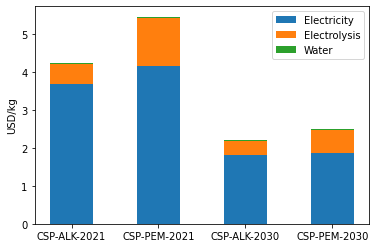

In [24]:
labels = ['CSP-ALK-2021',"CSP-PEM-2021","CSP-ALK-2030","CSP-PEM-2030"]
W = [LCOH(500,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.63,100000)[1],LCOH(1100,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.56)[1],LCOH(400,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.65,100000,0.15)[1],LCOH(650,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.63,percent_remp=0.15)[1]]
Electri = [LCOH(500,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.63,100000)[2],LCOH(1100,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.56)[2],LCOH(400,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.65,100000,0.15)[2],LCOH(650,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.63,percent_remp=0.15)[2]]
Electro = [LCOH(500,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.63,100000)[3],LCOH(1100,LCOE_csp_standalone_2021/1000,CF_elect_csp,0.56)[3],LCOH(400,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.65,100000,0.15)[3],LCOH(650,LCOE_csp_standalone_2030/1000,CF_elect_csp,0.63,percent_remp=0.15)[3]]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

bars = np.add(Electri, Electro).tolist()

ax.bar(labels, Electri, width, label='Electricity')
ax.bar(labels, Electro, width, bottom=Electri,label='Electrolysis')
ax.bar(labels, W, width, bottom=bars,label='Water')
ax.legend()

ax.set_ylabel("USD/kg")
#ax.set_title('Levelised Cost of Hydrogen - CSP')

#ax.bar(labels, women_means, width, bottom=men_means,label='Women')

In [25]:
i=3
Agua=W[i]*100/(W[i]+Electri[i]+Electro[i])
Agua

0.9503146316156438

In [26]:
Electricidad=Electri[i]*100/(W[i]+Electri[i]+Electro[i])
Electricidad

74.79134900218725

In [27]:
Electrolizador=Electro[i]*100/(W[i]+Electri[i]+Electro[i])
Electrolizador

24.25833636619712

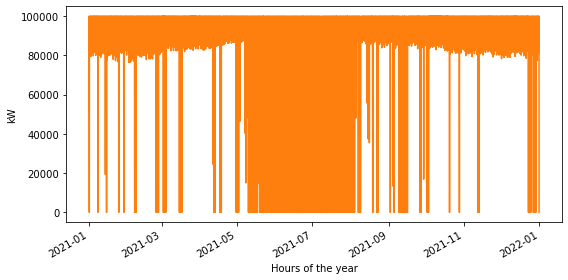

In [28]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')

ax.plot(pd.date_range(start='1/1/2021', end='01/01/2022',periods=8760),prod,c="tab:orange")
ax.set_ylabel('kW')
ax.set_xlabel('Hours of the year')
#ax.set_title('Hourly energy generated by the CSP system and hydrogen production')
#ax.legend(loc=2, ncol=3, bbox_to_anchor=(0.7, 0.2))
fig.autofmt_xdate()
#ax2 = ax.twinx()
#ax2.set_ylabel('kg/h')  # we already handled the x-label with ax1
#ax2.plot(pd.date_range(start='1/1/2021', end='01/01/2022',periods=8760),np.array(prod)*0.7/33.3,label='Hydrogen',c="tab:orange")

In [29]:
gen_csp=list(np.array(system_model_csp.Outputs.gen)*0.96)
Sum_Enero=sum(gen_csp[0:744])
Sum_Febrero=sum(gen_csp[744:1416])
Sum_Marzo=sum(gen_csp[1416:2160])
Sum_Abril=sum(gen_csp[2160:2880])
Sum_Mayo=sum(gen_csp[2880:3624])
Sum_Junio=sum(gen_csp[3624:4344])
Sum_Julio=sum(gen_csp[4344:5088])
Sum_Agosto=sum(gen_csp[5088:5832])
Sum_Septiembre=sum(gen_csp[5832:6552])
Sum_Octubre=sum(gen_csp[6552:7296])
Sum_Noviembre=sum(gen_csp[7296:8016])
Sum_Diciembre=sum(gen_csp[8016:8760])

Production =[Sum_Enero, Sum_Febrero, Sum_Marzo, Sum_Abril, Sum_Mayo, Sum_Junio, Sum_Julio, Sum_Agosto, Sum_Septiembre, Sum_Octubre, Sum_Noviembre,Sum_Diciembre]

In [30]:
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.56
eff_ALK=0.63

df1=pd.DataFrame(Production)
df1["PEM"]=(df1[0]/(LHV/eff_PEM + 6.4))*(LHV/eff_PEM)
df1["Liq"]=(df1[0]/(LHV/eff_PEM + 6.4))*6.4
df1["Alk"]=(df1[0]/(LHV/eff_ALK + 6.4))*(LHV/eff_ALK)
df1["Liq1"]=(df1[0]/(LHV/eff_ALK + 6.4))*6.4
df1["PEM1"]=(df1[0]/(LHV/eff_PEM + 1.05))*(LHV/eff_PEM)
df1["Comp"]=(df1[0]/(LHV/eff_PEM + 1.05))*1.05
df1["Alk1"]=(df1[0]/(LHV/eff_ALK + 1.05))*(LHV/eff_ALK)
df1["Comp1"]=(df1[0]/(LHV/eff_ALK + 1.05))*1.05

Months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
df1.index=Months
df1.columns=["Energy", "PEM","Liq","Alk","Liq1","PEM1","Comp","Alk1","Comp1"]

<ipython-input-31-227635ad8283>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_xticklabels(Months)
<ipython-input-31-227635ad8283>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 1].set_xticklabels(Months)
<ipython-input-31-227635ad8283>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 0].set_xticklabels(Months)
<ipython-input-31-227635ad8283>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 1].set_xticklabels(Months)


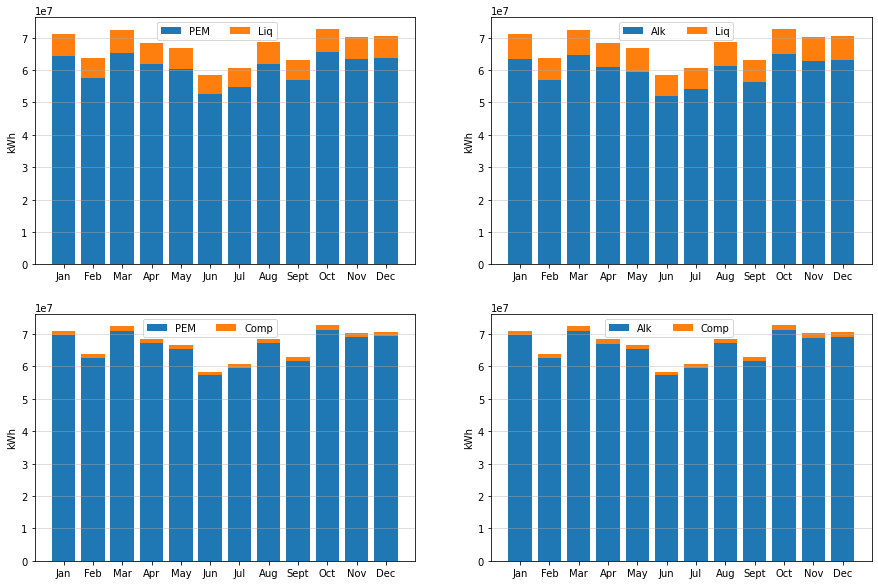

In [31]:
x=range(12)
fig, ax = plt.subplots(2, 2, constrained_layout=False)

fig.set_size_inches(15, 10)

ax[0, 0].bar(x=range(12), 
       height=df1["PEM"],
       label='PEM',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 0].bar(x=range(12), 
       height=df1["Liq"],
       bottom=df1["PEM"],
       label='Liq',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 0].set_ylabel('kWh')
#ax[0, 0].set_xlabel('Months')
#ax[0, 0].set_title('Monthly system power generated')
ax[0, 0].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[0, 0].set_xticklabels(Months)
ax[0, 0].set_xticks(range(12))
ax[0, 0].grid(alpha=0.5,axis='y')

ax[0, 1].bar(x=range(12), 
       height=df1["Alk"],
       label='Alk',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 1].bar(x=range(12), 
       height=df1["Liq1"],
       bottom=df1["Alk"],
       label='Liq',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 1].set_ylabel('kWh')
#ax[0, 1].set_xlabel('Months')
#ax[0, 1].set_title('Monthly system power generated')
ax[0, 1].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[0, 1].set_xticklabels(Months)
ax[0, 1].set_xticks(x)
ax[0, 1].grid(alpha=0.5,axis='y')

ax[1, 0].bar(x=range(12), 
       height=df1["PEM1"],
       label='PEM',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 0].bar(x=range(12), 
       height=df1["Comp"],
       bottom=df1["PEM1"],
       label='Comp',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 0].set_ylabel('kWh')
#ax[1, 0].set_xlabel('Months')
#ax[1, 0].set_title('Monthly system power generated')
ax[1, 0].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[1, 0].set_xticklabels(Months)
ax[1, 0].set_xticks(x)
ax[1, 0].grid(alpha=0.5,axis='y')

ax[1, 1].bar(x=range(12), 
       height=df1["Alk1"],
       label='Alk',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 1].bar(x=range(12), 
       height=df1["Comp1"],
       bottom=df1["Alk1"],
       label='Comp',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 1].set_ylabel('kWh')
#ax[1, 1].set_xlabel('Months')
#ax[1, 1].set_title('Monthly system power generated')
ax[1, 1].legend(loc=1, ncol=3, bbox_to_anchor=(0.65, 1))
ax[1, 1].set_xticklabels(Months)
ax[1, 1].set_xticks(x)
ax[1, 1].grid(alpha=0.5,axis='y')

In [32]:
#2021
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.56
eff_ALK=0.63
H2_PEM_Liq=(np.array(Production)/(LHV/eff_PEM+6.4))*(1/1000)
H2_PEM_Comp=(np.array(Production)/(LHV/eff_PEM+1.05))*(1/1000)
H2_Alk_Liq=(np.array(Production)/(LHV/eff_ALK+6.4))*(1/1000)
H2_Alk_Comp=(np.array(Production)/(LHV/eff_ALK+1.05))*(1/1000)

<ipython-input-33-b0e8452f57cc>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


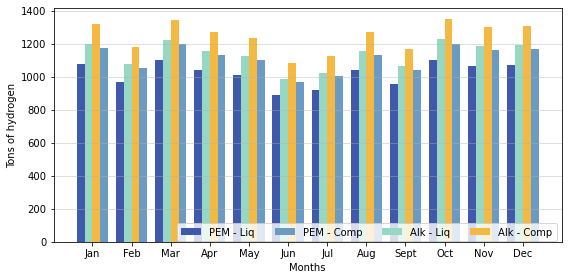

In [33]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
y=np.arange(12)
width1 = 0.2
ax.bar(y - 1.5*width1,
       height=H2_PEM_Liq,
       label="PEM - Liq",
       width=0.2, color="#4059AD"); 

ax.bar(y +1.5*width1, 
       height=H2_PEM_Comp,
       label='PEM - Comp',
       width=0.2,color="#6B9AC4"); 

ax.bar(y-0.5*width1, 
       height=H2_Alk_Liq,
       label='Alk - Liq',
       width=0.2,color="#97D8C4"); 

ax.bar(y + 0.5*width1, 
       height=H2_Alk_Comp,
       label='Alk - Comp',
       width=0.2, color="#F4B942"); 
       
ax.set_ylabel('Tons of hydrogen')
ax.set_xlabel('Months')
#ax.set_title('Monthly Hydrogen Production 2021')
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, 0.1))
ax.set_xticklabels(Months)
ax.set_xticks(y)
ax.grid(alpha=0.5,axis='y')

In [34]:
#2030
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.63
eff_ALK=0.65
H2_PEM_Liq=(np.array(Production)/(LHV/eff_PEM+6.4))*(1/1000)
H2_PEM_Comp=(np.array(Production)/(LHV/eff_PEM+1.05))*(1/1000)
H2_Alk_Liq=(np.array(Production)/(LHV/eff_ALK+6.4))*(1/1000)
H2_Alk_Comp=(np.array(Production)/(LHV/eff_ALK+1.05))*(1/1000)

<ipython-input-35-ba7c43fc328e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


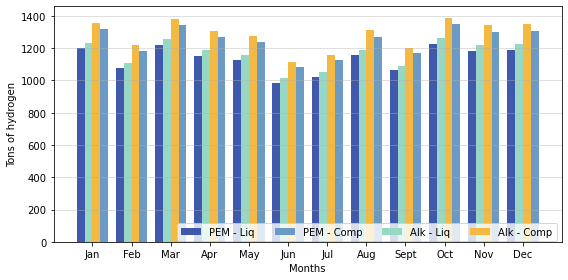

In [35]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
y=np.arange(12)
width1 = 0.2
ax.bar(y - 1.5*width1, 
       height=H2_PEM_Liq,
       label="PEM - Liq",
       width=0.2, color="#4059AD"); 

ax.bar(y +1.5*width1, 
       height=H2_PEM_Comp,
       label='PEM - Comp',
       width=0.2,color="#6B9AC4"); 

ax.bar(y-0.5*width1, 
       height=H2_Alk_Liq,
       label='Alk - Liq',
       width=0.2,color="#97D8C4"); 

ax.bar(y + 0.5*width1, 
       height=H2_Alk_Comp,
       label='Alk - Comp',
       width=0.2, color="#F4B942"); 
       
ax.set_ylabel('Tons of hydrogen')
ax.set_xlabel('Months')
#ax.set_title('Monthly Hydrogen Production 2021')
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, 0.1))
ax.set_xticklabels(Months)
ax.set_xticks(y)
ax.grid(alpha=0.5,axis='y')

In [36]:
day_prod=(sum(prod)/365)*0.63/33.3
flow_max=np.array(prod).max()*0.63/33.3

In [37]:
#Compressed hydrogen gas storage system

i=0.07
n_conversion=15
n_storage=20

FRC_conversion=(i*((1+i)**n_conversion))/(((1+i)**n_conversion)-1)
FRC_storage=(i*((1+i)**n_storage))/(((1+i)**n_storage)-1)

M_storage=2/100
M_conversion=4/100

storage_module=500*day_prod*((FRC_storage+M_storage)/(sum(prod)*0.63/33.3))  #USD
conversion_module=3900*flow_max*1.05*((FRC_conversion+M_conversion)/(sum(prod)*0.63/33.3))

GH2=storage_module+conversion_module

In [38]:
GH2

0.23473569205339484

In [39]:
#Liquid hydrogen

i=0.07
n_conversion=20
n_storage=20

FRC_conversion=(i*((1+i)**n_conversion))/(((1+i)**n_conversion)-1)
FRC_storage=(i*((1+i)**n_storage))/(((1+i)**n_storage)-1)

M_storage=2/100
M_conversion=8/100



storage_module=90*day_prod*((FRC_storage+M_storage)/(sum(prod)*0.63/33.3))  #USD
conversion_module=50000*flow_max*((FRC_conversion+M_conversion)/(sum(prod)*0.63/33.3))
LH2=storage_module+conversion_module

In [40]:
LH2

1.1374511112214691